##__<div style="text-align: center;">Vibration Data Analyze utilizing Apache Spark</div>__
####<div style="text-align: center;">_Steven Tsuang, Research Assistant, National Taiwan University._</div>
####This program is writen for conducting vibration.  The program featuring Apache Spark, a innovative distributing computer platform.

###__Introduction__
This is a case study of vibration condition in a hi-tech factory. It is 20-year 10-story-high moment frame structure located in Hsinchu science park (_figure 1_), Tawan. To analysis the vibration serviceability of the structure, a series of sensors was deployed in the 5<sup>th</sup> and the 9<sup>th</sup> and the basement.  
Uning these data, we will go though a series of structure analyze to discover the pattern of vibration condition. A abridge demo version of the analyze is also offered considering the 

###__Step 1 Importing data from CSV files__

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import *
import scipy
import scipy.fftpack
import pylab
from scipy import pi

In [8]:
from os import path #please keep a habit that import only needed modules rather than the whole package! 
import pandas as pd
import numpy as np

def importCsvRawData(filePath, fileName, channelOfInterest=' Channel 4'):
    csvFileDir=path.join(filePath,fileName)
    df = pd.read_csv(csvFileDir)                           # Open a Pandas data frame
    timeSeries=np.array(df[channelOfInterest],dtype='float')  # Float percision will suffice. (Double=2Float)
    timeSeries-=timeSeries.mean()
    return timeSeries,df 

filePath = "/Users/Apple/Documents/150824-EQwave"
fileName = "2015-07-01-00-00-27_131072.csv"

f9xm,df=importCsvRawData(filePath, fileName)
t= np.linspace(1,655.36,131072)

df.head(10)# Print the first 10 entries

,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,
0,-0.003027,-0.003331,0.001228,0.000211,-0.010568,0.000053,0.001761,-0.001294,
1,-0.003039,-0.003328,0.001207,0.000214,-0.010568,0.000063,0.001779,-0.001311,
2,-0.003047,-0.003326,0.001215,0.000226,-0.010580,0.000116,0.001767,-0.001278,
3,-0.003036,-0.003334,0.001202,0.000201,-0.010590,0.000115,0.001737,-0.001282,
4,-0.003044,-0.003321,0.001202,0.000232,-0.010556,0.000126,0.001770,-0.001298,
5,-0.003046,-0.003339,0.001232,0.000266,-0.010550,0.000126,0.001825,-0.001279,
6,-0.003041,-0.003340,0.001205,0.000244,-0.010620,0.000071,0.001737,-0.001291,
7,-0.003036,-0.003313,0.001214,0.000299,-0.010577,0.000095,0.001782,-0.001272,
8,-0.003048,-0.003349,0.001213,0.000272,-0.010559,0.000065,0.001791,-0.001279,
9,-0.003041,-0.003328,0.001212,0.000244,-0.010583,0.000068,0.001743,-0.001318,


For Future applications, let's define a sub-routine to plot any seismic time-series data.
The herebelow program returns a matplotlib.pyplot.figure.axes object, which features a format ready for use. By calling one of the object's function plot, it will plot the diagram. detail configureing on the plot could also be fine-tuned by mutating object'd parameters. Also, such object could be also stored in a list for iteration. 

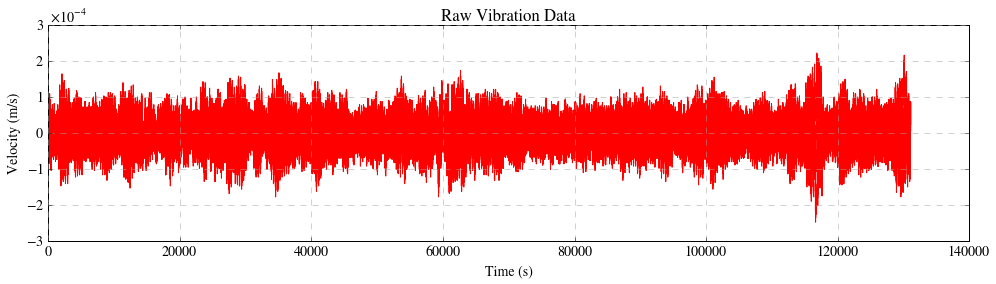

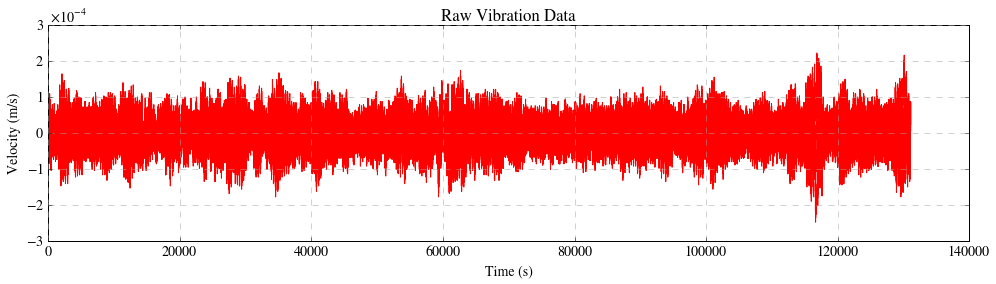

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

def plotTimeSeries(timeSeries=1,
                   figSize=(16,4),
                   dpi=200,
                   fileType = 'pdf',
                   storePath = ''):
    #Using STIX Font (which similar to Times New Roman)
    rcParams.update({'font.size': 14, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
    fig = plt.figure(figsize=figSize, dpi=dpi)
    axes = fig.add_axes([0.1, 0.15, 0.80, 0.75])

    #Set Title and Axis Labels
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Velocity (m/s)')
    axes.set_title('Raw Vibration Data')

    #Set Y-Axis Ticker Scientific Annotation 
    from matplotlib import ticker
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    axes.yaxis.set_major_formatter(formatter)
    axes.tick_params(axis='x')
    axes.tick_params(axis='y')

    #Set Grid Line
    axes.grid(color='#A4A4A4',alpha=1,linestyle='dashed',linewidth=0.5)
    #axes.plot(t,f9xm,'r',label="Measured 9F")# Notice that Latex math sign are fully supported!
    return axes

#ax=plotTimeSeries(f9xm)
plotTimeSeries().plot(f9xm,'r')

plotList=[]
plotList.append(plotTimeSeries().plot(f9xm,'r'))
for plot in plotList:
    print plot


####For reference:
Given a stationary velocity signal $\dot{x}(t)$ and corresponding frequency $\dot{X}(f)$. Its auto correlation function $R_{\dot{X}\dot{X}}$ is the expect value of the product of $\dot{X}(f)$ and $\dot{X}(f+\tau)$.
While its root-mean-square (RMS) value is the auto correlation function at $\tau=0$.

\begin{equation}
\sigma_{\dot{X}\dot{X}}^2=R_{\dot{X}\dot{X}}(0)=E[\dot{X}^2(f)]=\int_{-\infty}^{\infty}S_{\dot{X}\dot{X}}\,\mathrm{d}f
%S_{\dot{X}\dot{X}}(f)=E[\lim_{T\rightarrow\infty}\frac{|\dot{X}(f)|^2}{T}]
\end{equation}

Auto-spectral density function $S_{\dot{X}\dot{X}}$ are Symmetric to $f=0$, while $f \in (-\infty,\infty) $; The negative value are therefore folded to the positive value which become the one-sided auto spectral density function $G_{\dot{X}\dot{X}}(f)=2S_{\dot{X}\dot{X}}(f)$, where$f\in (0,\infty) $. Discrete In situ time domain data are transformed to frequency domain via discrete Fourier transform.

\begin{equation}
\sigma_{\dot{X}\dot{X}}^{2}(f_{ic})=2\int_{f_{il}}^{f_{iu}} S_{\dot{X}\dot{X}}(f)\,\mathrm{d}f=\int_{f_{il}}^{f_{iu}} G_{\dot{X}\dot{X}}(f)\,\mathrm{d}f\dots(1)
\end{equation}

Auto-spectral density function is the expect value of spectrum.

\begin{equation}
\sigma_{\dot{X}\dot{X}}(f_{ic})=\sqrt{\frac{2}{N^2}\sum_{k_l}^{k_u}{|X[k]|^2}}
\end{equation}

Where $k_u=f_{iu}NT_s$, $k_l=f_{il}NT_s$ is the upper and lower bounding of the corresponding frequency band.
$T_s$ is sampling period, L is the number of data segments while N is data length for each segment.
After obtaining the Auto-spectral density function.
The integration of one-sided auto spectral density function $G_{xx}(f)$ between upper band $f_{iu}$ and lower band $f_{il}$ are the mean square velocity at central frequency $f_{ic}$.
Finally, root-mean-square velocity can be obtained by taking the square root of mean square velocity.

Another subroutine, fourierSpectrum, was defined to generate Fourier spectrum. It is good for plotting non-stational data like seismic event.

notice that the spectrum can also be ploted in Decibel (dB) scale, which is much perferred in modern engineering application.

131072


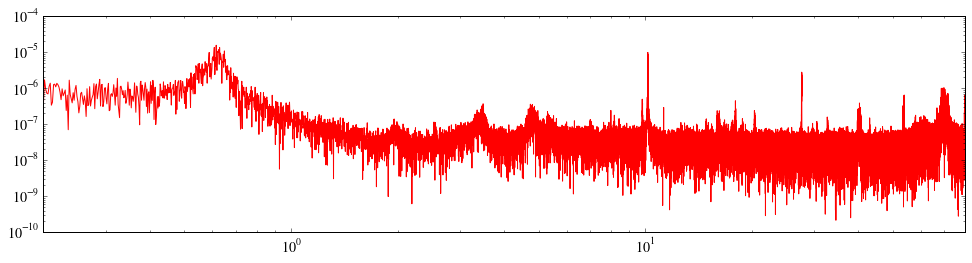

In [5]:
from numpy import fft.fft as fft
from scipy import fftpack.fftfreq as fftfreq

def fourierSpectrum(timeSeries):
    half=
    output=2*abs(fft(timeSeries))/timeseries.size # formula (1)
    freqs = scipy.fftpack.fftfreq(F9XM.size,0.005)
    

def plotFourierSpectrum(frequencyDomain):
    fig = plt.figure(figsize=(16,4), dpi=200)
    axes = fig.add_axes([0.1, 0.15, 0.80, 0.75])# Setting left, bottom, width, height (range 0 to 1)
    #axes.plot(freqs,20*scipy.log10(F9XM),'r',label="Measured 9F")# Notice that Latex math sign are fully supported!
    axes.set_xscale("log")
    axes.set_yscale("log")
    axes.set_xlim(0.2,80)
    axes.set_ylim(1e-10,1e-4)
    F9XM=2*abs(np.fft.fft(f9xm))/131072

axes.plot(freqs[:65536],F9XM[:65536],'r')




However, raw fourier spectrum is too caprice to identify any meaningful iinformation in high frequency range. Therefore, in most ambient vibration analysis, 

will multipied with a window function. this step can a avoid leaking effect during discrete fourier transformation. But window function will also causes the weight at both end of the data series being underestimated, so the divid into segment which outlap with each other to avoid such error. 

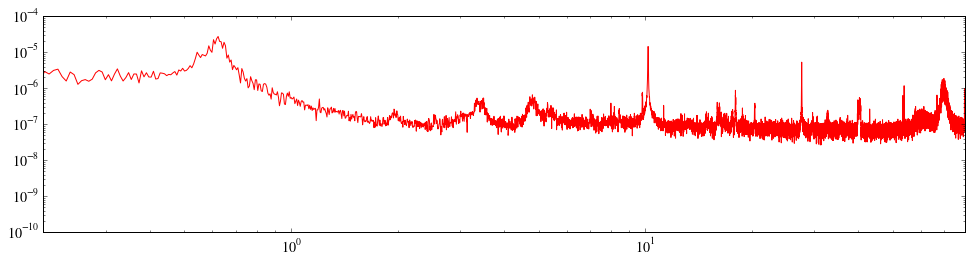

In [6]:
u=f9xm[:-16384].reshape(7,16384)
l=f9xm[16384:].reshape(7,16384)

d=hstack((u,l))

w=np.hanning(32768)

D=2*abs(np.fft.fft(d))/32768

D=1.5*D.mean(axis=0)

fig = plt.figure(figsize=(16,4), dpi=200)
axes = fig.add_axes([0.1, 0.15, 0.80, 0.75])# Setting left, bottom, width, height (range 0 to 1)
#axes.plot(freqs,20*scipy.log10(F9XM),'r',label="Measured 9F")# Notice that Latex math sign are fully supported!
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim(0.2,80)
axes.set_ylim(1e-10,1e-4)

freqs = scipy.fftpack.fftfreq(D.size,0.005)
axes.plot(freqs[:16384],D[:16384],'r')

#f9xm.size-16384

####Define the band width of octave band, the factor of octave are mutable.
####As the are 

In [37]:
from math import log,pow
def octaveBandWidth (n=12,upper=100,lower=0.2):
    f=np.arange(log(upper/lower,2)*n)
    lf=np.vectorize(lambda x: pow(2,(x-0.5)/n)*lower)(f)
    cf=np.vectorize(lambda x: pow(2,x/n)*lower)(f)
    uf=np.vectorize(lambda x: pow(2,(x+0.5)/n)*lower)(f)
    return vstack((lf,cf,uf))

octaveBandWidth().T[0:10,:]

array([[ 0.19430639,  0.2       ,  0.20586045],
       [ 0.20586045,  0.21189262,  0.21810155],
       [ 0.21810155,  0.22449241,  0.23107054],
       [ 0.23107054,  0.23784142,  0.24481071],
       [ 0.24481071,  0.25198421,  0.25936791],
       [ 0.25936791,  0.26696797,  0.27479073],
       [ 0.27479073,  0.28284271,  0.29113064],
       [ 0.29113064,  0.29966142,  0.30844217],
       [ 0.30844217,  0.31748021,  0.32678309],
       [ 0.32678309,  0.33635857,  0.34621462]])

####And the way~~~ we go !

In [8]:
fD=np.vstack((freqs[:16384],D[:16384])).T
a1=filter(lambda (f,m):f>99.8,fD)
a2=map(lambda (f,m):m*m,a1)
sqrt(sum(a2))


3.7319121556468763e-07

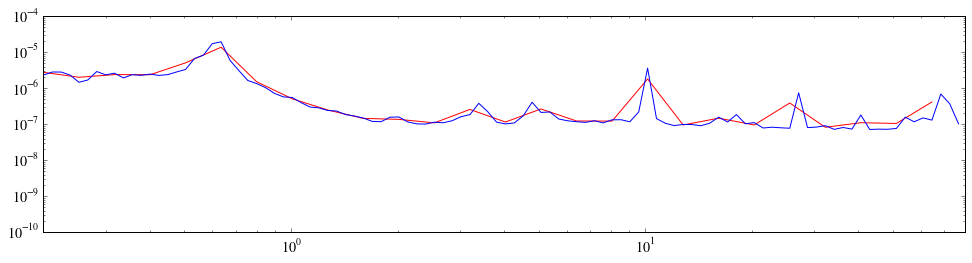

In [36]:
def octaveBand (s,n):
    freqs = scipy.fftpack.fftfreq(D.size,0.005)
    result=[]
    for b in octaveBandWidth(n=n,lower=0.2,upper=80).T:
        a1=filter(lambda (f,m):(f>b[0])&(f<b[2]),s)
        a2=map(lambda (f,m):m*m,a1)
        result.append((b[1],sqrt(sum(a2)/len(a2))))
    return array(result)

fig = plt.figure(figsize=(16,4), dpi=200)
axes = fig.add_axes([0.1, 0.15, 0.80, 0.75])# Setting left, bottom, width, height (range 0 to 1)
#axes.plot(freqs,20*scipy.log10(F9XM),'r',label="Measured 9F")# Notice that Latex math sign are fully supported!
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim(0.2,80)
axes.set_ylim(1e-10,1e-4)
ob=octaveBand (fD,1)

ob12=octaveBand (fD,12)
ob3=octaveBand (fD,3)
axes.plot(ob3[:,0],ob3[:,1],'r',ob12[:,0],ob12[:,1],'b')



It's onerous to run all hereabove cell before accessing these function.
by importing package 

####Second, let's produce its 1/3 Octave band spectrum. 

0.0300075018755 4000


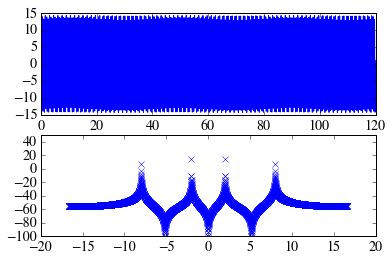

In [74]:
t = scipy.linspace(0,120,4000)
acc = lambda t: 10*scipy.sin(2*pi*2.0*t) + 5*scipy.sin(2*pi*8.0*t) #+ 2*scipy.random.random(len(t))

signal = acc(t)

FFT = abs(scipy.fft(signal))/signal.size
freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])

print  t[1]-t[0],t.size

pylab.subplot(211)
pylab.plot(t, signal)
pylab.subplot(212)
pylab.subplot(212).set_ylim(-100,50)
pylab.plot(freqs,20*scipy.log10(FFT),'x')

pylab.show()

####EEMD